In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import mean_squared_error
from pathlib import Path

# Adjust the path if needed
df = pd.read_csv("C:\\Users\\niyim\\Desktop\\IntroCSS\\kddm2\\challenge.csv")

shape = df.shape      
head = df.head(3)
print("Shape:", shape)  # just to see rows, columns
print("Head:\n", head)  # quick peek   

Shape: (991, 636)
Head:
    Latitude (N)  Longitude (E)  1888-11-05 01:05:21  1888-11-05 02:05:21  \
0     46.593193      11.466003                -0.12                -0.25   
1     47.236404      11.192179                -0.07                -0.74   
2     46.765167      11.525469                 0.52                 0.96   

   1888-11-05 03:05:21  1888-11-05 04:05:21  1888-11-05 05:05:21  \
0                -6.07               -12.60               -17.09   
1                -0.84                -1.51                -3.45   
2                 1.19                 1.48                 1.88   

   1888-11-05 06:05:21  1888-11-05 07:05:21  1888-11-05 08:05:21  ...  \
0               -23.39               -26.98               -31.82  ...   
1                -5.06                -5.94                -6.22  ...   
2                 2.16                 2.63                 2.89  ...   

   1888-12-01 01:05:21  1888-12-01 02:05:21  1888-12-01 03:05:21  \
0              -330.67              

In [2]:
# Coordinates
coords = df.iloc[:, 0:2].to_numpy()   # shape (n_rows, 2)

# Time series values (everything after longitude)
values = df.iloc[:, 2:].to_numpy()    # shape (n_rows, n_times)

n_rows, n_times = values.shape
n_rows, n_times
print("n_rows:", n_rows, "   n_times:", n_times)


test_idx = 0   # to change later

from numpy.linalg import norm

def coord_distance(p, q):
    """
    p, q: arrays of shape (2,) containing [lat, lon]
    returns Euclidean distance
    """
    return norm(p - q)

def get_k_nearest_neighbors(coords, target_idx, k=5, exclude_last=True):
    target_coord = coords[target_idx]

    distances = []
    for i in range(len(coords)):
        if i == target_idx:
            continue
        if exclude_last and i == len(coords) - 1:
            continue
        d = coord_distance(target_coord, coords[i])
        distances.append((i, d))

    # sort by distance
    distances.sort(key=lambda x: x[1])

    # take first k
    neighbor_indices = [idx for idx, d in distances[:k]]
    return neighbor_indices


# ============================
# Revamp: timestamp outliers + seasonal modeling
# ============================

def clean_outliers_per_timestamp(values, z_thresh=6.0):
    """
    Remove timestamp-specific measurement errors across sensors.
    Uses median+MAD per timestamp column.
    """
    v = values.copy()
    n_rows, n_times = v.shape
    ref_rows = np.arange(n_rows - 1)  # exclude missing row

    for t in range(n_times):
        col = v[ref_rows, t]
        col = col[np.isfinite(col)]
        if col.size < 20:
            continue

        med = np.median(col)
        mad = np.median(np.abs(col - med))
        if mad == 0:
            continue

        robust_z = np.abs(v[:, t] - med) / (1.4826 * mad)
        v[robust_z > z_thresh, t] = np.nan

    return v


def fill_nans_timewise(values):
    """
    Fill NaNs within each known sensor row by linear interpolation over time.
    Leaves last row untouched (it is fully missing).
    """
    v = values.copy()
    n_rows, n_times = v.shape
    x = np.arange(n_times)

    for i in range(n_rows - 1):
        y = v[i, :]
        mask = np.isfinite(y)
        if mask.sum() < 2:
            continue
        v[i, ~mask] = np.interp(x[~mask], x[mask], y[mask])

    return v


def fit_fourier_season(ts, period=24, n_harm=3):
    """
    Simple trend + Fourier seasonality regression.
    Returns fitted seasonal signal and residual.
    """
    y = ts.astype(float)
    n = len(y)
    t = np.arange(n)

    X = [np.ones(n), t]
    for k in range(1, n_harm + 1):
        X.append(np.sin(2 * np.pi * k * t / period))
        X.append(np.cos(2 * np.pi * k * t / period))
    X = np.column_stack(X)

    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    resid = y - y_hat
    return y_hat, resid


def reconstruct_missing_row_seasonal(values_filled, coords, target_idx,
                                     k_near=50, k_use=10,
                                     period=24, n_harm=3,
                                     resid_weight=0.25):
    """
    1) Take k_near nearest by distance
    2) Choose k_use most consistent by correlation of seasonal fits
    3) Predict as weighted avg of seasonal fits + small residual blend
    """
    cand = get_k_nearest_neighbors(coords, target_idx, k=k_near, exclude_last=False)

    # seasonal fits for candidates
    fits = []
    for idx in cand:
        y_hat, _ = fit_fourier_season(values_filled[idx, :], period=period, n_harm=n_harm)
        fits.append(y_hat)
    fits = np.vstack(fits)

    # normalize fits for correlation scoring
    fits_z = (fits - fits.mean(axis=1, keepdims=True)) / (fits.std(axis=1, keepdims=True) + 1e-8)
    C = np.corrcoef(fits_z)
    avg_corr = np.nanmean(C, axis=1)

    top = np.argsort(avg_corr)[-k_use:]
    chosen = [cand[i] for i in top]

    # distance weights among chosen
    dists = np.array([coord_distance(coords[target_idx], coords[i]) for i in chosen])
    dists = np.where(dists == 0, 1e-6, dists)
    w = 1.0 / dists
    w = w / w.sum()

    # build prediction from chosen seasonal fits and residuals
    fit_chosen = []
    resid_chosen = []
    for i in chosen:
        y_hat, r = fit_fourier_season(values_filled[i, :], period=period, n_harm=n_harm)
        fit_chosen.append(y_hat)
        resid_chosen.append(r)

    fit_chosen = np.vstack(fit_chosen)
    resid_chosen = np.vstack(resid_chosen)

    seasonal_pred = (w[:, None] * fit_chosen).sum(axis=0)
    resid_pred = resid_weight * (w[:, None] * resid_chosen).sum(axis=0)

    return seasonal_pred + resid_pred, chosen


neighbor_indices = get_k_nearest_neighbors(coords, test_idx, k=5)
print(neighbor_indices)

n_rows: 991    n_times: 634
[131, 850, 341, 149, 973]


In [3]:
# ============================
# Final step: reconstructing the real missing row (last row)
# ============================

# 1. Choosing the final hyperparameters (based on my validation)
best_k = 10
best_power = 1

# 2. To identify the index of the real missing row
target_idx_real = n_rows - 1  # last row in the dataset

# --- Revamp pipeline ---
values_clean = clean_outliers_per_timestamp(values, z_thresh=6.0)
values_filled = fill_nans_timewise(values_clean)

reconstructed_real_row, chosen_neighbors = reconstruct_missing_row_seasonal(
    values_filled, coords, target_idx_real,
    k_near=50, k_use=10,
    period=24, n_harm=3,
    resid_weight=0.25
)

print("Chosen neighbors (seasonal method):", chosen_neighbors)
print("NaNs in prediction:", np.isnan(reconstructed_real_row).sum())

print("\nReconstructing real missing row at index:", target_idx_real)
print("Coordinates of missing row:", coords[target_idx_real])

# Optional: quick peek at the first 10 predicted values
print("First 10 predicted values for the missing row:",
      reconstructed_real_row[:10])

Chosen neighbors (seasonal method): [794, 663, 933, 736, 83, 203, 266, 194, 857, 521]
NaNs in prediction: 0

Reconstructing real missing row at index: 990
Coordinates of missing row: [47.26694107 11.38928699]
First 10 predicted values for the missing row: [-60.32362483 -59.41563323 -58.7652974  -58.34227256 -58.05520245
 -57.76679866 -57.57844991 -57.53959832 -57.81350848 -58.42217495]


In [4]:
from pathlib import Path

# Put prediction into df (optional)
df.iloc[target_idx_real, 2:] = reconstructed_real_row

nan_ct = np.isnan(reconstructed_real_row).sum()
print("NaNs in prediction:", nan_ct)

# === SUBMISSION FILE: one row only ===
here = Path.cwd()
out_path = here / "19_New.csv"   # rename to required naming scheme

submission = df.iloc[[target_idx_real], :].copy()  # keep it as a 1-row dataframe
submission.to_csv(out_path, index=False)

print("Saved submission (1 row) to:", out_path)
print("Submission shape:", submission.shape)

NaNs in prediction: 0
Saved submission (1 row) to: c:\Users\niyim\Downloads\19_New.csv
Submission shape: (1, 636)


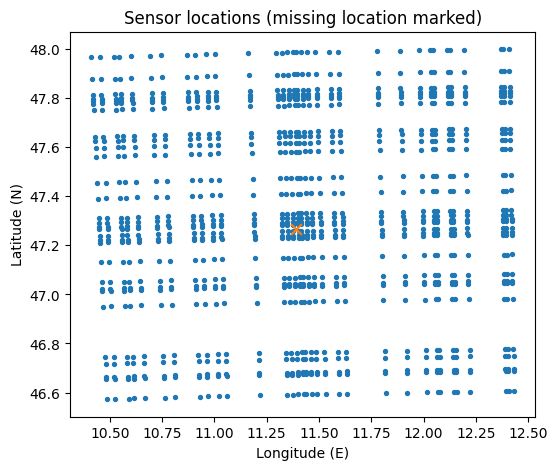

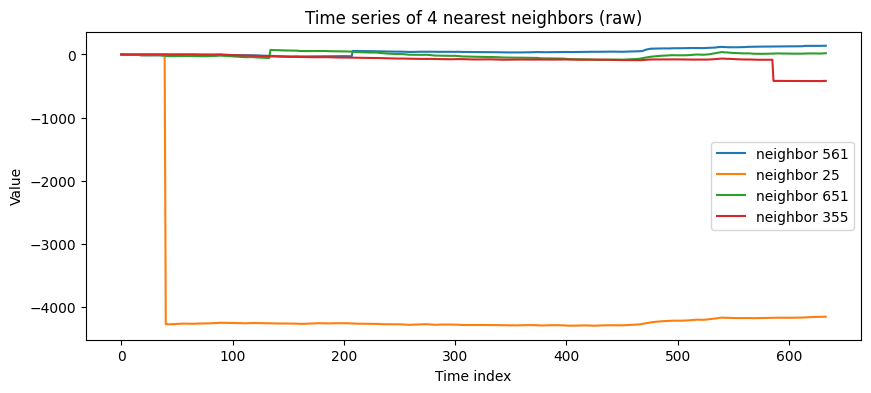

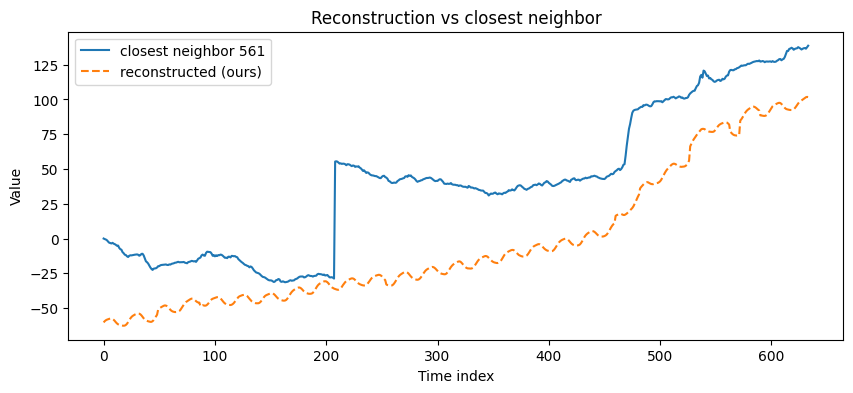

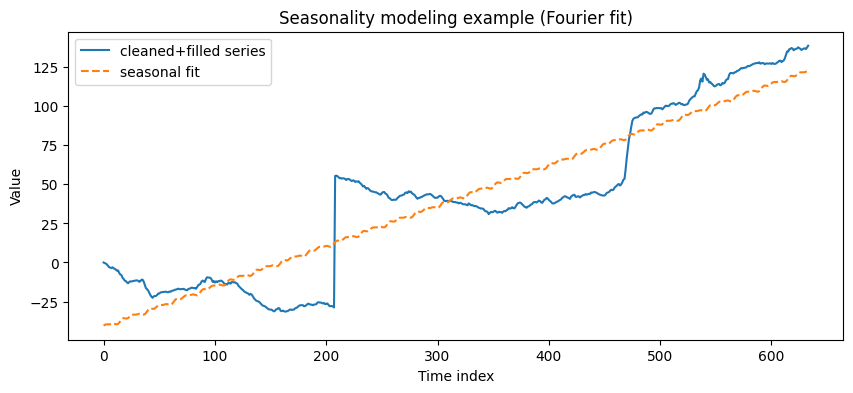

In [5]:
# ============================
# Poster plots
# ============================
import matplotlib.pyplot as plt

time_cols = df.columns[2:]
t = np.arange(len(time_cols))

# Plot 1: sensor map + missing point
plt.figure(figsize=(6,5))
plt.scatter(coords[:-1, 1], coords[:-1, 0], s=8)  # lon, lat
plt.scatter(coords[-1, 1], coords[-1, 0], s=60, marker="x")
plt.xlabel("Longitude (E)")
plt.ylabel("Latitude (N)")
plt.title("Sensor locations (missing location marked)")
plt.show()

# Plot 2: a few nearest neighbors time series (raw)
target_idx_real = n_rows - 1
nn = get_k_nearest_neighbors(coords, target_idx_real, k=4, exclude_last=False)

plt.figure(figsize=(10,4))
for i in nn:
    plt.plot(t, values[i, :], label=f"neighbor {i}")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.title("Time series of 4 nearest neighbors (raw)")
plt.legend()
plt.show()

# Plot 3: reconstructed series vs closest neighbor
closest = nn[0]
plt.figure(figsize=(10,4))
plt.plot(t, values[closest, :], label=f"closest neighbor {closest}")
plt.plot(t, reconstructed_real_row, label="reconstructed (ours)", linestyle="--")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.title("Reconstruction vs closest neighbor")
plt.legend()
plt.show()

# Plot 4: show seasonality fit for one neighbor (illustration)
y_hat, resid = fit_fourier_season(values_filled[closest, :], period=24, n_harm=3)
plt.figure(figsize=(10,4))
plt.plot(t, values_filled[closest, :], label="cleaned+filled series")
plt.plot(t, y_hat, label="seasonal fit", linestyle="--")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.title("Seasonality modeling example (Fourier fit)")
plt.legend()
plt.show()
